In [1]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle

from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from scipy.stats import rankdata

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [6]:
metrics =  [
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity',
    #'Model Parameter Randomisation'
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    # 'baseline_mean', not used anymore as there's some probs with quantus implementation
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]

transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': abs,
    'Faithfulness Correlation': abs, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: -parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"
dataset = "imagenet"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

In [16]:
# check if recomputed metrics are done
#import os

#metrics2 =  [
#    'Monotonicity Nguyen',
#    'Local Lipschitz Estimate',
#    'Faithfulness Estimate',
#    'Faithfulness Correlation',
#    'Avg-Sensitivity',
#    'Random Logit',
#    'Max-Sensitivity',
#    #'Sparseness', 
#    #'EffectiveComplexity',
#    'Monotonicity Arya',
#    #'Complexity',
#    'Pixel-Flipping',
#    #'Selectivity',
#    'Model Parameter Randomisation'
#]

#filenames = []
#for metr in metrics2:
#    if metr in metrics_with_different_baselines:
#        for baseline in baselines:
#            for meth in methods:
#                filenames.append(f'{meth}_{model}_{dataset}_{metr}_{baseline}.csv')
#    else:
#        for meth in methods:
#            filenames.append(f'{meth}_{model}_{dataset}_{metr}.csv')

#existing_files = set(os.listdir('csv_new'))
#lacking_files = [f for f in filenames if f not in existing_files]
#sorted(lacking_files)

['polycam_resnet50_imagenet_Avg-Sensitivity.csv',
 'polycam_resnet50_imagenet_Local Lipschitz Estimate.csv',
 'polycam_resnet50_imagenet_Max-Sensitivity.csv',
 'polycam_resnet50_imagenet_Model Parameter Randomisation.csv',
 'rise_resnet50_imagenet_Model Parameter Randomisation.csv']

In [7]:
CSV_DIR = "csv_merged"

for metr in metrics:
    if metr in metrics_with_different_baselines:
        for baseline in baselines:
            data = pd.DataFrame()
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            for meth in methods:
                csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data[meth] = transform[metr](df).values.flatten()    
            ranks = np.array([rankdata(-p) for p in data.values])
            average_ranks = np.mean(ranks, axis=0)
            dico_ranks[metr_with_baseline] = average_ranks
#    elif metr == 'Model Parameter Randomisation':
#        for baseline in ['bottom_up','top_down']:
#            data = pd.DataFrame()
#            metr_with_baseline = f'{metr} with {baseline}'
#            print(f"-- Metric: {metr_with_baseline}")
#            for meth in methods:
#                csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
#                df = pd.read_csv(csv_name, header = None)
#                data[meth] = transform[metr](df).values.flatten()    
#            ranks = np.array([rankdata(-p) for p in data.values])
#            average_ranks = np.mean(ranks, axis=0)
#            dico_ranks[metr_with_baseline] = average_ranks
    else:
        data = pd.DataFrame()
        print(f"-- Metric: {metr}")
        for meth in methods:
            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
            df = pd.read_csv(csv_name, header = None)
            data[meth] = transform[metr](df).values.flatten()    
        ranks = np.array([rankdata(-p) for p in data.values])
        average_ranks = np.mean(ranks, axis=0)
        dico_ranks[metr] = average_ranks

with open('rankings_by_rank_aggreg.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

-- Metric: Monotonicity Nguyen with baseline_black
-- Metric: Monotonicity Nguyen with baseline_random
-- Metric: Monotonicity Nguyen with baseline_uniform
-- Metric: Monotonicity Nguyen with baseline_white
-- Metric: Local Lipschitz Estimate
-- Metric: Faithfulness Estimate with baseline_black
-- Metric: Faithfulness Estimate with baseline_random
-- Metric: Faithfulness Estimate with baseline_uniform
-- Metric: Faithfulness Estimate with baseline_white
-- Metric: Faithfulness Correlation with baseline_black
-- Metric: Faithfulness Correlation with baseline_random
-- Metric: Faithfulness Correlation with baseline_uniform
-- Metric: Faithfulness Correlation with baseline_white
-- Metric: Avg-Sensitivity
-- Metric: Random Logit
-- Metric: Max-Sensitivity
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Monotonicity Arya with baseline_black
-- Metric: Monotonicity Arya with baseline_random
-- Metric: Monotonicity Arya with baseline_uniform
-- Metric: Monotonicity Arya with 

In [49]:
with open('rankings_by_rank_aggreg.pickle', 'rb') as file:
    dico_ranks = pickle.load(file)

In [50]:
df_ranks = pd.DataFrame(dico_ranks, index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [51]:
df_ranks

,Monotonicity Nguyen with baseline_black,Monotonicity Nguyen with baseline_random,Monotonicity Nguyen with baseline_uniform,Monotonicity Nguyen with baseline_white,Local Lipschitz Estimate,Faithfulness Estimate with baseline_black,Faithfulness Estimate with baseline_random,Faithfulness Estimate with baseline_uniform,Faithfulness Estimate with baseline_white,Faithfulness Correlation with baseline_black,...,Monotonicity Arya with baseline_white,Complexity,Pixel-Flipping with baseline_black,Pixel-Flipping with baseline_random,Pixel-Flipping with baseline_uniform,Pixel-Flipping with baseline_white,Selectivity with baseline_black,Selectivity with baseline_random,Selectivity with baseline_uniform,Selectivity with baseline_white
integratedgrad,6.4895,4.9300,6.0520,6.2470,5.740,7.5770,4.7700,7.3135,8.7415,6.9030,...,7.61375,2.2475,4.7435,2.6100,3.1105,3.2300,4.0605,4.7590,4.5450,4.2115
smoothgrad,4.9260,4.8615,4.7195,4.6885,8.991,4.9695,4.8150,4.6530,4.3545,5.6520,...,6.06050,7.2575,5.5125,5.3450,6.0640,5.3000,5.2280,5.3605,5.2385,5.2505
guidedbackprop,6.0015,6.4725,6.6805,5.5245,3.415,7.8655,8.2380,8.9505,7.9180,6.9440,...,8.12300,1.1100,3.3420,6.5455,4.1130,3.7775,5.0745,5.4295,5.3330,5.1930
rise,6.2510,6.7455,6.6715,6.7130,5.168,5.2120,5.5615,5.2450,5.2130,5.2860,...,5.19700,10.3920,6.1405,5.2995,6.2490,6.5015,5.5590,5.6440,5.6100,5.6380
gradcam,4.6210,4.6625,4.2475,4.7915,5.511,4.6620,5.2110,4.5675,4.7520,5.0030,...,5.21150,4.6825,6.9130,6.0145,6.4395,7.1985,7.5160,7.0310,7.1665,7.4085
scorecam,4.7525,4.7760,4.3575,4.8645,5.680,4.9090,5.5300,4.8215,4.9500,5.3695,...,5.28100,6.1470,7.0665,6.1195,6.6445,7.4205,7.4160,7.0035,7.0740,7.2160
layercam,4.7330,4.5685,4.3470,4.8885,7.495,4.8450,5.4845,4.8550,4.9390,5.6520,...,5.64925,8.5530,6.9835,6.1605,6.7030,7.3770,7.3715,6.9520,7.1005,7.3325
random,8.4835,8.2330,8.5610,8.7295,10.895,10.1440,10.1245,9.6455,10.0135,7.1815,...,8.58500,6.6595,4.2675,6.8545,5.4850,3.4885,3.8245,4.4445,4.3330,3.9230
sobel,8.0660,9.0265,8.9080,8.0370,1.000,5.6725,5.6285,5.8520,5.5085,6.7770,...,5.28050,3.2680,7.4585,8.1935,6.9675,7.4680,5.6985,6.1420,6.0395,5.8965
gaussian,6.4330,6.4505,6.5165,6.5030,2.000,5.1035,5.3615,5.1405,4.9305,5.9170,...,2.77575,10.3080,7.2500,7.0515,7.2695,8.0320,7.1590,6.3460,6.6100,6.9080


In [11]:
def compute_kendall_w(dico_ranks, metrics):
    rankings = [rankdata(dico_ranks[metric]) for metric in metrics]
        
    data = []
    for i in range(len(rankings[0])):
        data.append([rankings[j][i] for j in range(len(rankings))])   
    
    # source of the implementation : https://github.com/ugolbck/kendall-w/blob/master/kendall_w/kendall_w.py
    m = len(data[0])
    n = len(data)
    sums = [sum(x) for x in data]
    Rbar = sum(sums) / n
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])
    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W

In [12]:
def compute_kendall_tau(dico_ranks, metrics):
    tau_values = []
    p_values = []

    for metric_a in metrics:
        current_tau_values = []
        current_p_values = []
        for metric_b in metrics:
            tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
            current_tau_values.append(tau)
            current_p_values.append(p_value)
        tau_values.append(current_tau_values)
        p_values.append(current_p_values)
        
    return tau_values, p_values

In [13]:
def plot_corr_matrix(tau_values, p_values, labels, masked=False, show=True, save=False, path='', fig_size=(23.4,16.54), rotate=False):
    sn.set(rc={'figure.figsize': fig_size})
    if masked:
        # given that tau_values is symmetric, we take into account only the p-values below the diagonal 
        p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
        reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
        mask = np.ones((len(labels),len(labels)), dtype=bool)
        reject = np.invert(reject)
        current_post = 0
        for i in range(len(labels)):
            for j in range(i):
                mask[i][j] = reject[current_post]
                current_post += 1
            mask[i][i] = False
        
        sn.heatmap(tau_values,
                   annot=True,
                   vmin=-1,
                   vmax=1,
                   xticklabels=labels,
                   yticklabels=labels,
                   mask=mask,
                   cmap='viridis')
    else:
        mask = np.ones((len(labels),len(labels)), dtype=bool)
        for i in range(len(labels)):
            for j in range(i+1):
                mask[i][j] = False
        
        sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=labels,
           yticklabels=labels,
           mask=mask,
           cmap='viridis')
    
    if rotate:
        plt.xticks(rotation=0)
    if save:
        plt.savefig(path, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

## All metrics with all baselines 

In [14]:
tau_values, p_values = compute_kendall_tau(dico_ranks, metrics_with_baselines)

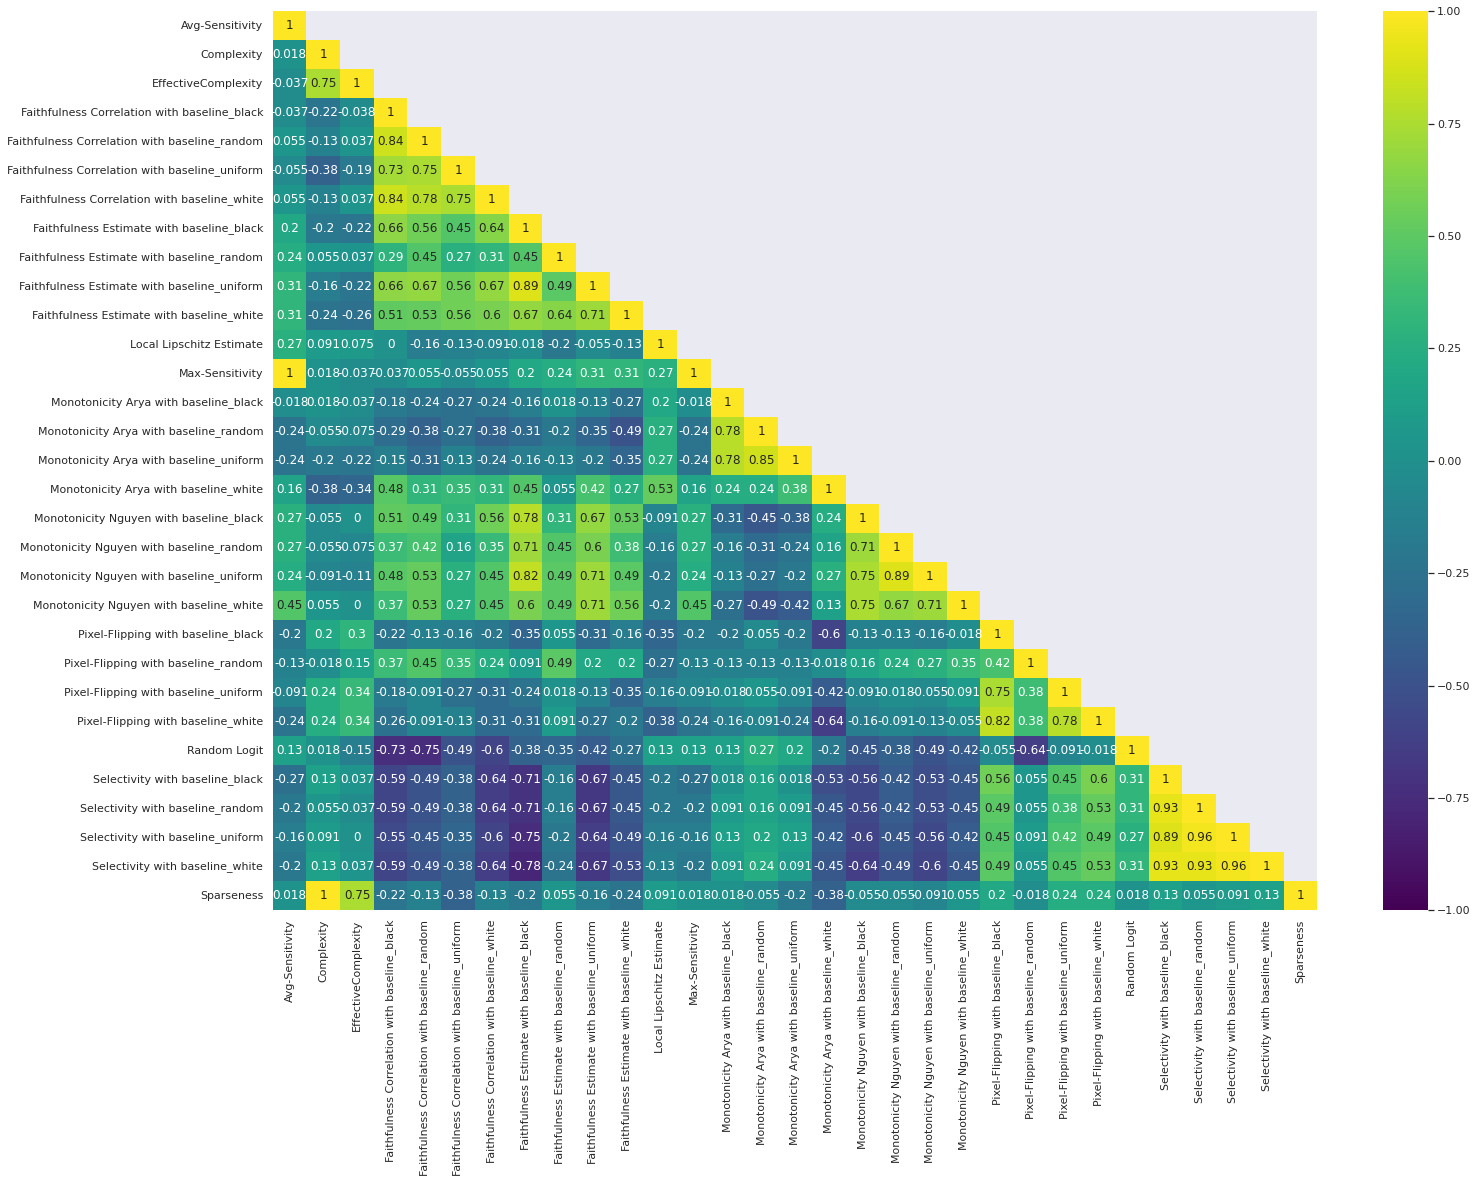

In [15]:
plot_corr_matrix(tau_values, p_values, metrics_with_baselines)

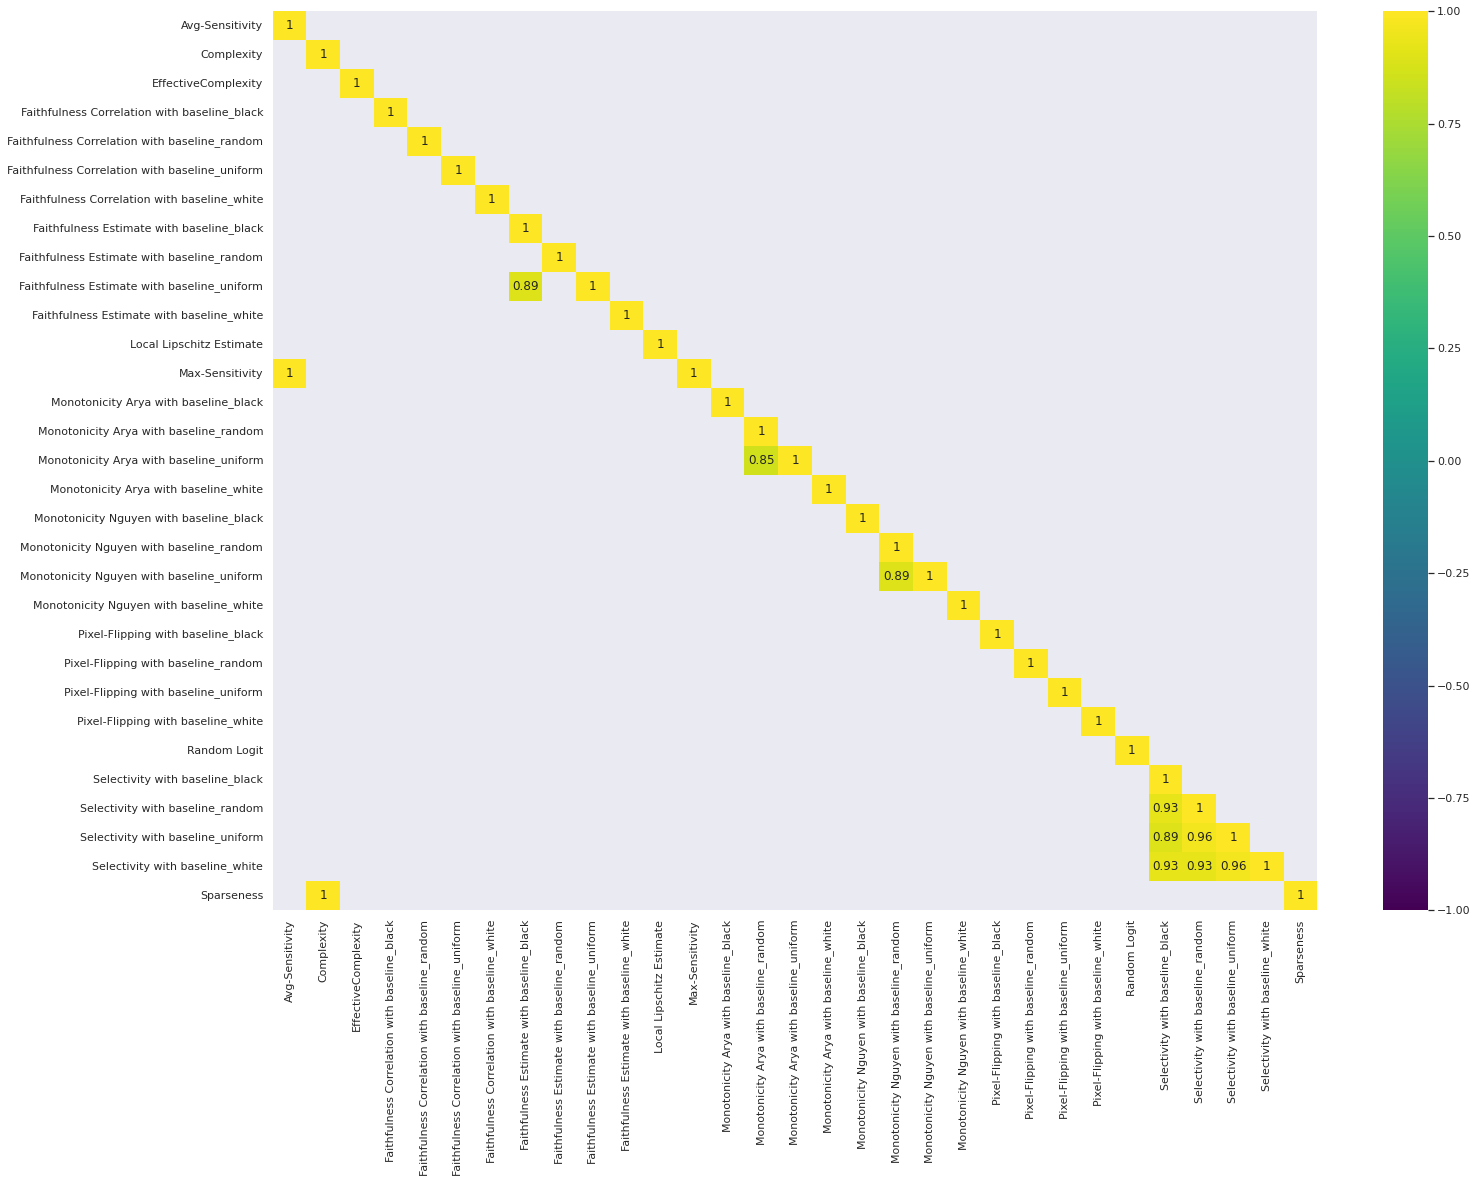

In [16]:
# Correlation Matrix with only significative values (Holm Correction)
plot_corr_matrix(tau_values, p_values, metrics_with_baselines, masked=True, save=True, path='./results/corr_matrix_rank_aggreg_holm_corr.png')

In [17]:
compute_kendall_w(dico_ranks, metrics_with_baselines)

0.06122883360136222

## Faithfulness Estimate with various baselines 

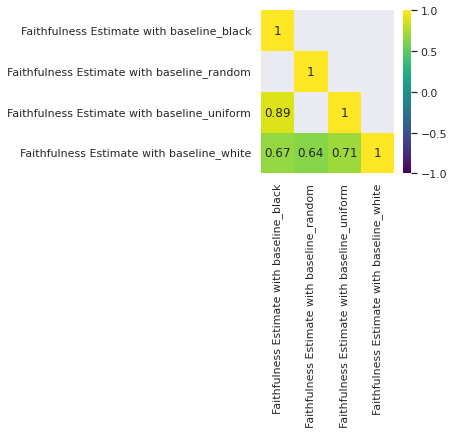

In [18]:
selected_metrics = [m for m in metrics_with_baselines if 'Faithfulness Estimate' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_faithfulness_estimate.png', fig_size=(3,3))

In [19]:
compute_kendall_w(dico_ranks, selected_metrics)

0.7863636363636364

## Faithfulness Correlation with various baselines 

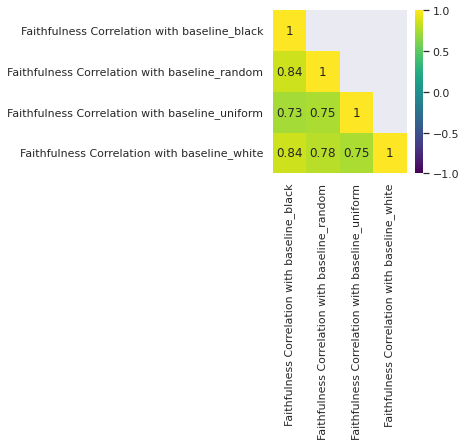

In [20]:
selected_metrics = [m for m in metrics_with_baselines if 'Faithfulness Correlation' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_faithfulness_correlation.png', fig_size=(3,3))

In [21]:
compute_kendall_w(dico_ranks, selected_metrics)

0.9315340909090909

## Monotonicity Arya with various baselines 

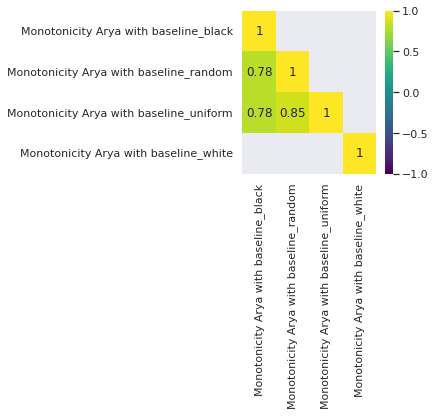

In [22]:
selected_metrics = [m for m in metrics_with_baselines if 'Monotonicity Arya' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_monotonicity_arya.png', fig_size=(3,3))

In [23]:
compute_kendall_w(dico_ranks, selected_metrics)

0.6988636363636364

## Monotonicity Nguyen with various baselines 

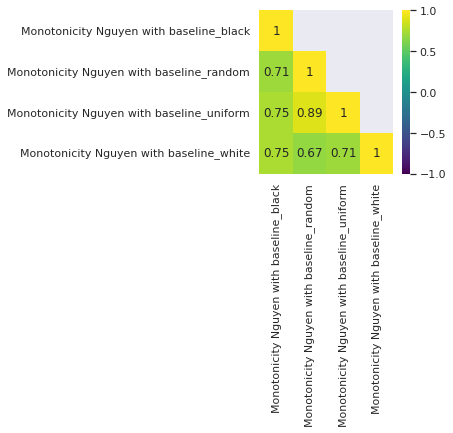

In [24]:
selected_metrics = [m for m in metrics_with_baselines if 'Monotonicity Nguyen' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_monotonicity_nguyen.png', fig_size=(3,3))

In [25]:
compute_kendall_w(dico_ranks, selected_metrics)

0.9215909090909091

## Pixel-Flipping with various baselines 

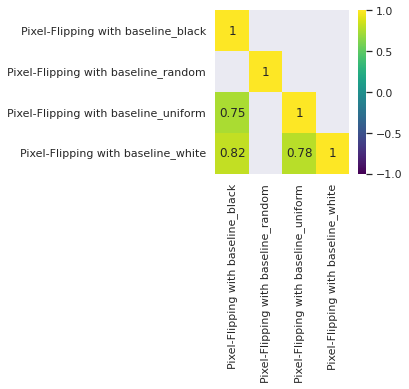

In [26]:
selected_metrics = [m for m in metrics_with_baselines if 'Pixel-Flipping' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_pixel_flipping.png', fig_size=(3,3))

In [27]:
compute_kendall_w(dico_ranks, selected_metrics)

0.7681818181818182

## Selectivity with various baselines 

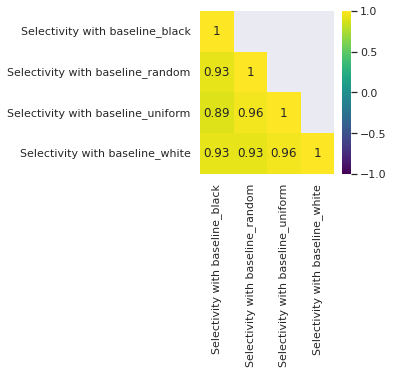

In [28]:
selected_metrics = [m for m in metrics_with_baselines if 'Selectivity' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_selectivity.png', fig_size=(3,3))

In [29]:
compute_kendall_w(dico_ranks, selected_metrics)

0.9875

## Faithfulness metrics with baseline_black

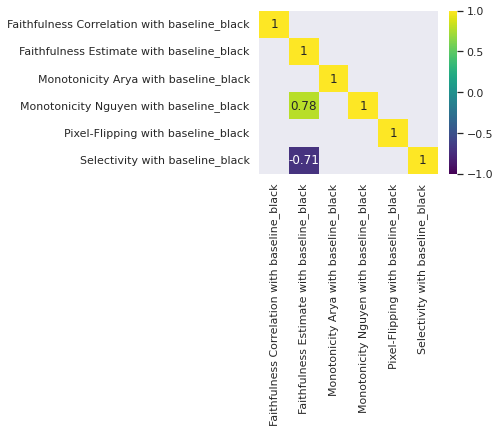

In [54]:
selected_metrics = [m for m in metrics_with_baselines if 'baseline_black' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_baseline_black.png', fig_size=(4,3))

In [55]:
compute_kendall_w(dico_ranks, selected_metrics)

0.08068181818181819

## Faithfulness metrics with baseline_white

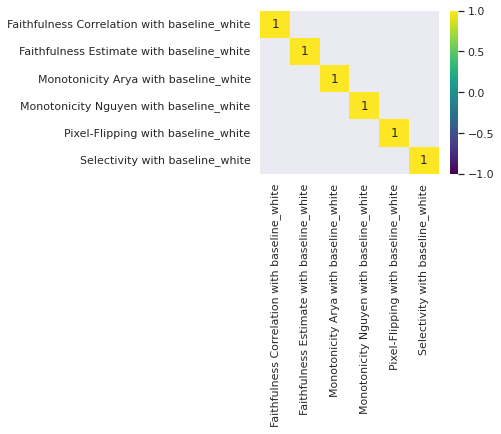

In [56]:
selected_metrics = [m for m in metrics_with_baselines if 'baseline_white' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_baseline_white.png', fig_size=(4,3))

In [57]:
compute_kendall_w(dico_ranks, selected_metrics)

0.14343434343434344

## Faithfulness metrics with baseline_random

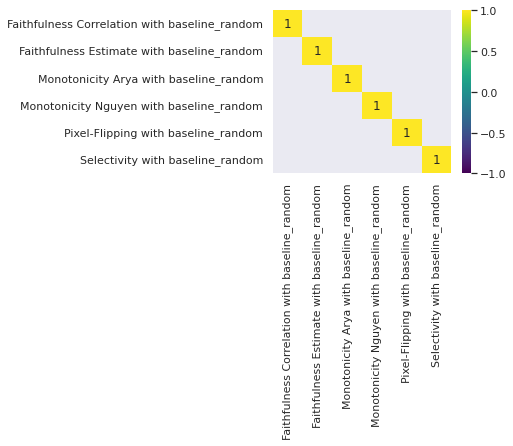

In [58]:
selected_metrics = [m for m in metrics_with_baselines if 'baseline_random' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_baseline_random.png', fig_size=(4,3))

In [59]:
compute_kendall_w(dico_ranks, selected_metrics)

0.22676767676767676

## Faithfulness metrics with baseline_uniform

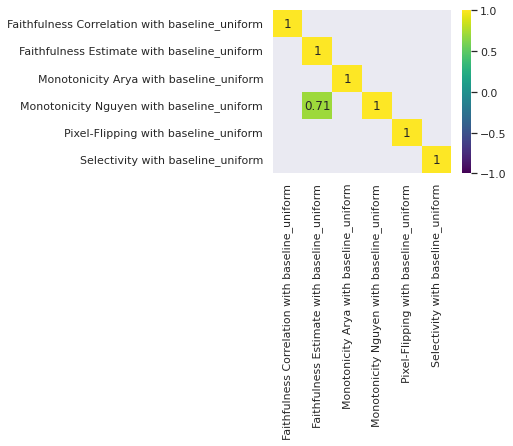

In [60]:
selected_metrics = [m for m in metrics_with_baselines if 'baseline_uniform' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_baseline_uniform.png', fig_size=(4,3))

In [61]:
compute_kendall_w(dico_ranks, selected_metrics)

0.11060606060606061

## All metrics with default baselines 

In [30]:
final_dico_ranks = {}

for metr in metrics:
    if metr in metrics_with_different_baselines:
        metr_with_baseline = f'{metr} with baseline_black'
        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
#    elif metr == 'Model Parameter Randomisation':
#        metr_with_baseline = f'{metr} with bottom_up'
#        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
    else:
        final_dico_ranks[metr] = dico_ranks[metr]
        
final_metrics = sorted(final_dico_ranks.keys())

In [31]:
final_tau_values, final_p_values = compute_kendall_tau(final_dico_ranks, final_metrics)

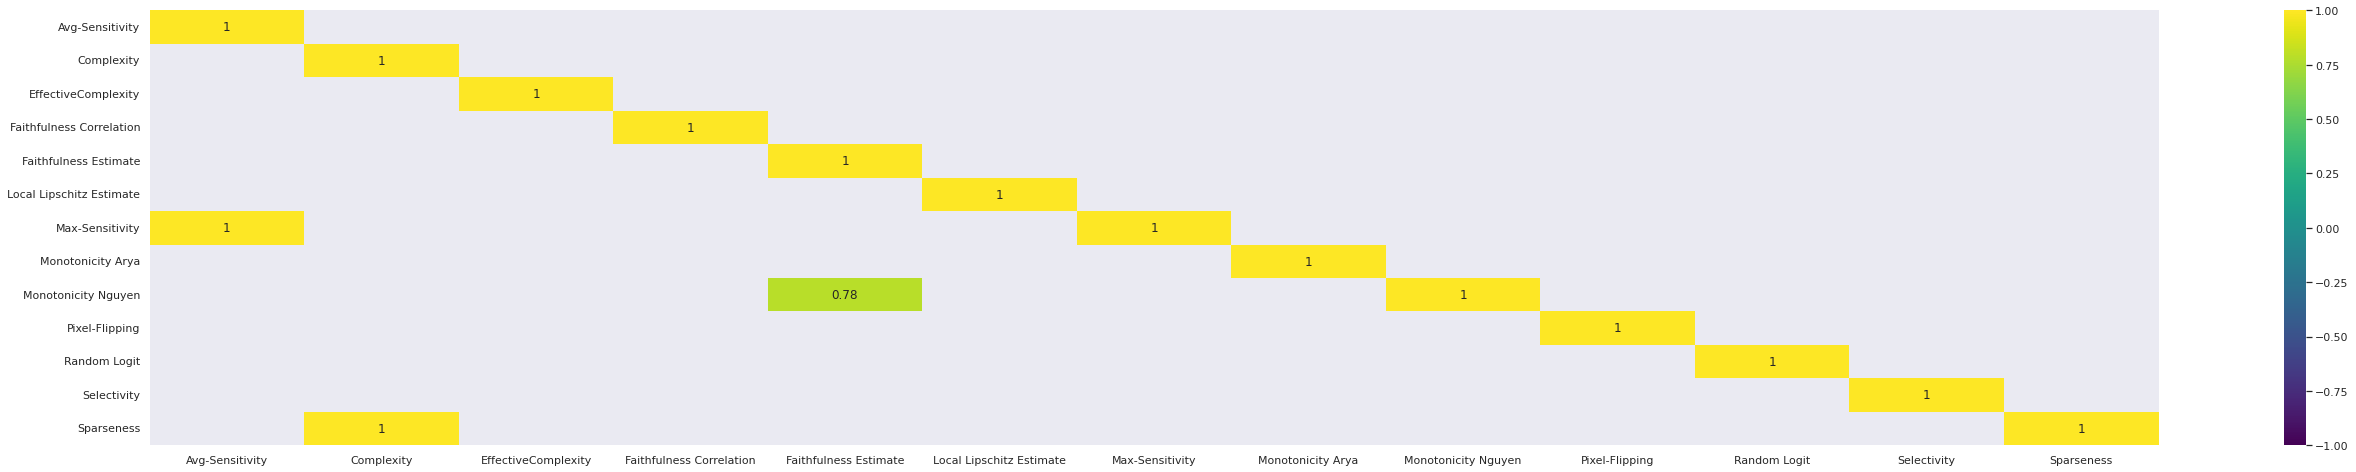

In [32]:
plot_corr_matrix(final_tau_values, final_p_values, final_metrics, masked=True,
                 save=True, path='./results/final_corr_matrix_rank_aggreg_holm_corr.png', fig_size=(45,8), rotate=True)

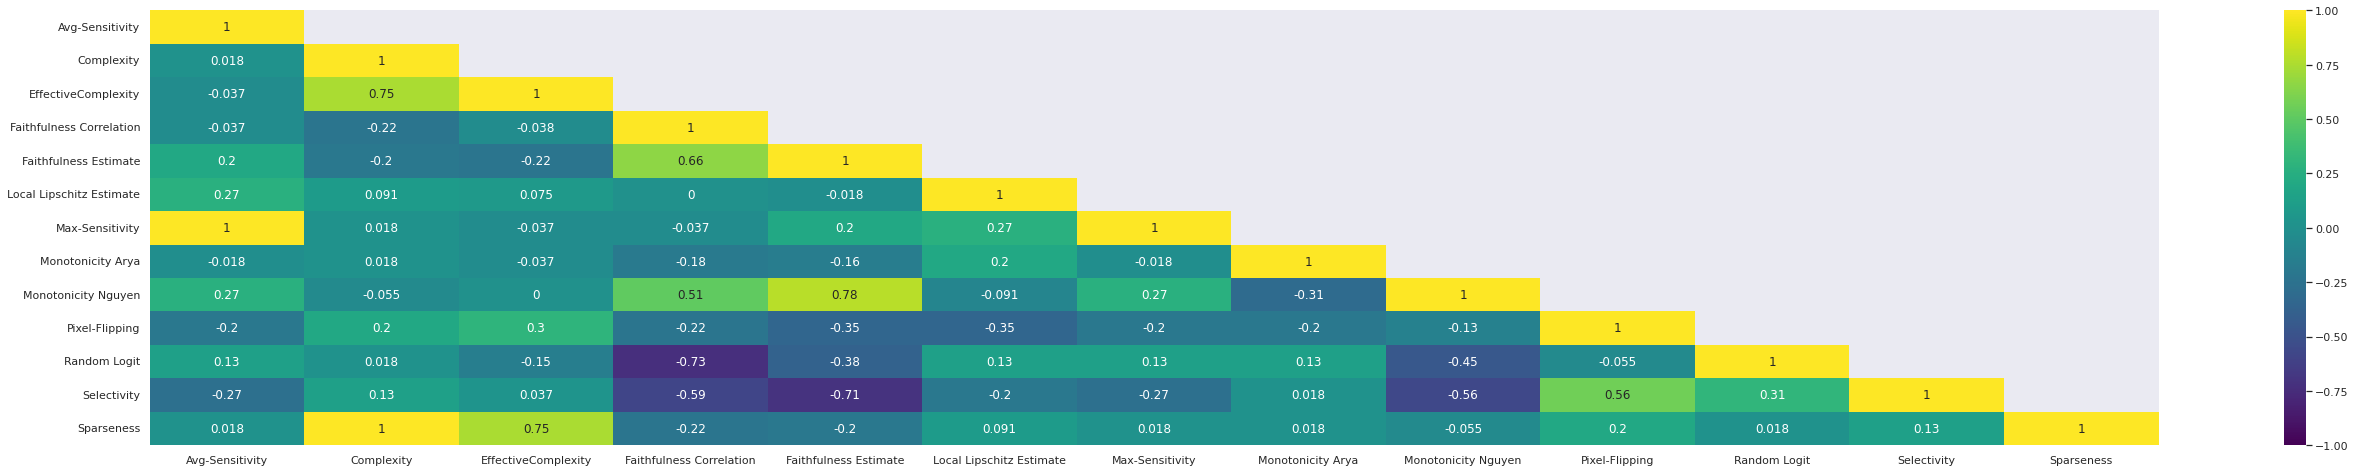

In [33]:
plot_corr_matrix(final_tau_values, final_p_values, final_metrics, masked=False,
                 save=True, path='./results/final_corr_matrix_rank_aggreg.png', fig_size=(45,8), rotate=True)

## Faithfulness

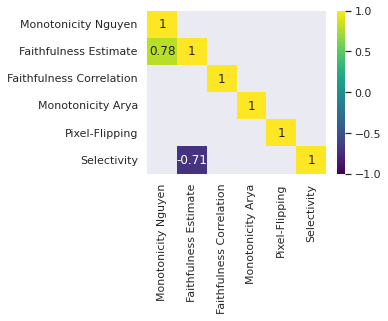

In [34]:
selected_metrics = ['Monotonicity Nguyen','Faithfulness Estimate','Faithfulness Correlation','Monotonicity Arya','Pixel-Flipping','Selectivity']
selected_tau_values, selected_p_values = compute_kendall_tau(final_dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True,
                 save=True, path='./results/final_corr_matrix_rank_aggreg_holm_corr_faithfulness.png', fig_size=(4,3), rotate=False)

In [35]:
for i, metric_a in enumerate(selected_metrics):
    for j, metric_b in enumerate(selected_metrics):
        if i < j:
            print(f'{metric_a} / {metric_b} : {selected_tau_values[i][j]} ({selected_p_values[i][j]})')

Monotonicity Nguyen / Faithfulness Estimate : 0.7818181818181819 (0.0003334435626102293)
Monotonicity Nguyen / Faithfulness Correlation : 0.5137830903923016 (0.028783965875738386)
Monotonicity Nguyen / Monotonicity Arya : -0.3090909090909091 (0.21834651074234407)
Monotonicity Nguyen / Pixel-Flipping : -0.1272727272727273 (0.6480954385121052)
Monotonicity Nguyen / Selectivity : -0.5636363636363636 (0.016540504248837583)
Faithfulness Estimate / Faithfulness Correlation : 0.6605782590758164 (0.004936818556325083)
Faithfulness Estimate / Monotonicity Arya : -0.16363636363636364 (0.5422593494468494)
Faithfulness Estimate / Pixel-Flipping : -0.34545454545454546 (0.16457331248997917)
Faithfulness Estimate / Selectivity : -0.7090909090909091 (0.0015912097162097162)
Faithfulness Correlation / Monotonicity Arya : -0.18349396085439343 (0.43487965849578347)
Faithfulness Correlation / Pixel-Flipping : -0.2201927530252721 (0.3487366601388052)
Faithfulness Correlation / Selectivity : -0.5871806747340

In [36]:
compute_kendall_w(final_dico_ranks, selected_metrics)

0.08068181818181819

## Complexity

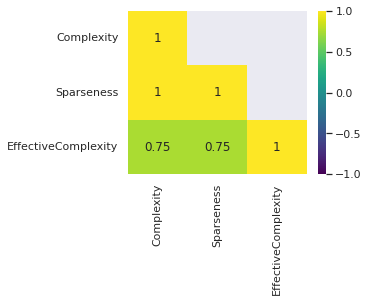

In [37]:
selected_metrics = ['Complexity','Sparseness','EffectiveComplexity']
selected_tau_values, selected_p_values = compute_kendall_tau(final_dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True,
                 save=True, path='./results/final_corr_matrix_rank_aggreg_holm_corr_complexity.png', fig_size=(4,3), rotate=False)

In [38]:
for i, metric_a in enumerate(selected_metrics):
    for j, metric_b in enumerate(selected_metrics):
        if i < j:
            print(f'{metric_a} / {metric_b} : {selected_tau_values[i][j]} ({selected_p_values[i][j]})')

Complexity / Sparseness : 1.0 (5.010421677088344e-08)
Complexity / EffectiveComplexity : 0.7479575920067657 (0.0016372747184498855)
Sparseness / EffectiveComplexity : 0.7479575920067657 (0.0016372747184498855)


In [39]:
compute_kendall_w(final_dico_ranks, selected_metrics)

0.9414141414141414

## Randomization

In [40]:
selected_metrics = ['Random Logit','Model Parameter Randomisation']
selected_tau_values, selected_p_values = compute_kendall_tau(final_dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True,
                 save=True, path='./results/final_corr_matrix_rank_aggreg_holm_corr_randomisation.png', fig_size=(4,3), rotate=False)

KeyError: 'Model Parameter Randomisation'

In [ ]:
for i, metric_a in enumerate(selected_metrics):
    for j, metric_b in enumerate(selected_metrics):
        if i < j:
            print(f'{metric_a} / {metric_b} : {selected_tau_values[i][j]} ({selected_p_values[i][j]})')

In [ ]:
compute_kendall_w(final_dico_ranks, selected_metrics)

## Robustness

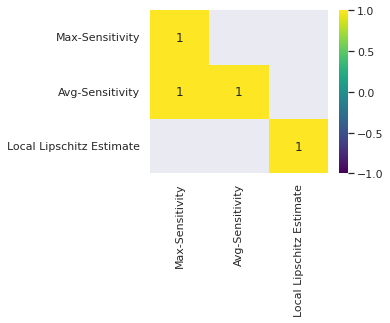

In [41]:
selected_metrics = ['Max-Sensitivity','Avg-Sensitivity','Local Lipschitz Estimate']
selected_tau_values, selected_p_values = compute_kendall_tau(final_dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True,
                 save=True, path='./results/final_corr_matrix_rank_aggreg_holm_corr_robustness.png', fig_size=(4,3), rotate=False)

In [42]:
for i, metric_a in enumerate(selected_metrics):
    for j, metric_b in enumerate(selected_metrics):
        if i < j:
            print(f'{metric_a} / {metric_b} : {selected_tau_values[i][j]} ({selected_p_values[i][j]})')

Max-Sensitivity / Avg-Sensitivity : 1.0 (5.010421677088344e-08)
Max-Sensitivity / Local Lipschitz Estimate : 0.2727272727272727 (0.2829668209876543)
Avg-Sensitivity / Local Lipschitz Estimate : 0.2727272727272727 (0.2829668209876543)


In [43]:
compute_kendall_w(final_dico_ranks, selected_metrics)

0.7090909090909091

## Other combinaisons of metrics

In [44]:
compute_kendall_w(final_dico_ranks, ['Avg-Sensitivity', 'Max-Sensitivity'])

1.0

In [ ]:
compute_kendall_w(final_dico_ranks, ['Faithfulness Estimate','Model Parameter Randomisation'])

In [45]:
compute_kendall_w(final_dico_ranks, ['Monotonicity Nguyen', 'Faithfulness Correlation', 'Monotonicity Arya'])

0.29343434343434344

In [46]:
compute_kendall_w(final_dico_ranks, ['Local Lipschitz Estimate', 'Random Logit', 'Sparseness', 'EffectiveComplexity', 'Complexity'])

0.456

In [47]:
compute_kendall_w(final_dico_ranks, ['Pixel-Flipping','Selectivity'])

0.8772727272727273

# Figures for article

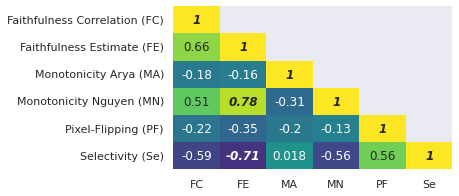

In [48]:
selected_metrics = ['Faithfulness Correlation','Faithfulness Estimate', 'Monotonicity Arya','Monotonicity Nguyen','Pixel-Flipping','Selectivity']
labels = ['Faithfulness Correlation (FC)','Faithfulness Estimate (FE)','Monotonicity Arya (MA)','Monotonicity Nguyen (MN)','Pixel-Flipping (PF)','Selectivity (Se)']
short_labels = ['FC','FE', 'MA','MN','PF','Se']

tau_values, p_values = compute_kendall_tau(final_dico_ranks, selected_metrics)

p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')

sn.set(rc={'figure.figsize': (5,3)})

p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
mask = np.ones((len(labels),len(labels)), dtype=bool)
current_post = 0
for i in range(len(labels)):
    for j in range(i):
        mask[i][j] = reject[current_post]
        current_post += 1

sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           cbar=False,
           xticklabels=short_labels,
           yticklabels=labels,
           mask=mask,
           cmap='viridis')

mask = np.ones((len(labels),len(labels)), dtype=bool)
current_post = 0
for i in range(len(labels)):
    for j in range(i):
        mask[i][j] = not reject[current_post]
        current_post += 1
    mask[i][i] = False

sn.heatmap(tau_values,
           annot=True,
           annot_kws={"style": "italic", "weight": "bold"},
           vmin=-1,
           vmax=1,
           cbar=False,
           xticklabels=short_labels,
           yticklabels=labels,
           mask=mask,
           cmap='viridis')

plt.xticks(rotation=0)
plt.savefig('./results/final_corr_matrix_rank_aggreg_holm_corr_faithfulness.eps', bbox_inches='tight', format='eps')
plt.show()
plt.close()